In [1]:


import torch

from torch.utils.data import Dataset, DataLoader



from torchvision import transforms as T, utils

import matplotlib.pyplot as plt
from PIL import Image





#ab diffusion related imports
from AB_diffusion.user_hints import RandomHintGenerator, get_color_hints 
from AB_diffusion.color_handling import de_normalize_lab, normalize_lab,plotMinMax
from AB_diffusion.ab_denoising_diffusion_pytorch import ABUnet, ABGaussianDiffusion
from AB_diffusion.ab_trainer import ABDataset
from AB_diffusion.colorizer_app import ColorizerApp
from IPython.utils import io as iol
from skimage import io
from kornia.color import rgb_to_lab, lab_to_rgb
from datasets import load_from_disk,load_dataset
#from ab_classifier_free_guidance import *


import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import random
import glob
import mplcursors
import ipywidgets as widgets
from IPython.display import display
import torchvision.transforms as transforms




/Home/siv32/eve036/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 802: system not yet initialized (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
/Home/siv32/eve036/.local/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Home/siv32/eve036/.local/lib/python3.6/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [2]:
! python -c "import torch; print(torch.cuda.is_available())"


/Home/siv32/eve036/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 802: system not yet initialized (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
False


In [3]:
device = torch.device(6 if torch.cuda.is_available() else "cpu")
print(device)
print("Selected GPU:", torch.cuda.get_device_name(device))
#check wicj gpu is selected
torch.cuda.set_device(device)

cpu


RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 802: system not yet initialized

In [ ]:
unet = ABUnet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    out_dim = 2,
    channels=5
    )

def load(model_name,folder):
    print(str(folder  + f'/{model_name}'))
    data = torch.load(str(folder  + f'/{model_name}'), map_location=device)
    return data

diffusion_model = ABGaussianDiffusion(
        unet,
        image_size = 256,
        timesteps = 1000,
        objective = 'pred_v',
        beta_schedule = 'sigmoid',
        min_snr_loss_weight = False,
)
with iol.capture_output() as captured:

    model_folder = "./models"
    model_name = "model-pred_v-1000-sigmoid-256-3x3000steps.pt"
    loaded_data = load(model_name,model_folder)
    diffusion_model.load_state_dict(loaded_data['model'])
    diffusion_model.to(device)




timesteps 1000


In [31]:
test_folder = "./data/sem images/val"

#dataset = ABDataset(load_dataset("imagenet-1k",split="validation"),image_size=256)
dataset = ABDataset(load_dataset("imagefolder", data_dir=test_folder)["train"],image_size=64)
dataloader = DataLoader(dataset, batch_size = 1, shuffle = True, pin_memory = True,num_workers=100//6)

Resolving data files:   0%|          | 0/99 [00:00<?, ?it/s]

Using custom data configuration default-812357fbd4547404
Reusing dataset imagefolder (/Home/siv32/eve036/.cache/huggingface/datasets/imagefolder/default-812357fbd4547404/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


  0%|          | 0/1 [00:00<?, ?it/s]

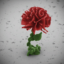

In [32]:
#img = Image.open("./test_img.png")
##convert to torch tensor
#img
imgL, imgAB = next(iter(dataloader))

#cat them together, convert to rgb and display
imgLAB = torch.cat((imgL,imgAB),dim=1)
imgRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(imgLAB).squeeze(0).detach().cpu()
            )
        )


imgRGB


In [49]:
class RandomHintGenerator2:
    def __init__(self, p=1/8, min_hints=1, min_size=1, max_size=9, whole_ab_p=0.01):
        self.p = p
        self.min_hints = min_hints
        self.min_size = min_size
        self.max_size = max_size
        self.whole_ab_p = whole_ab_p

    def get_num_hints(self, batch_size):
        dist = torch.distributions.Geometric(self.p)
        num_hints = dist.sample((batch_size,)) + 1
        num_hints = torch.clamp(num_hints, min=self.min_hints)
        return num_hints

    def get_sample_locations(self, num_hints, H, W):
        mean = torch.Tensor([0.5*H, 0.5*W])
        covariance_matrix = torch.diag(torch.Tensor([(H/4)**2, (W/4)**2]))
        dist = torch.distributions.MultivariateNormal(mean, covariance_matrix)
        locations = dist.sample((num_hints.max().int(),))
        locations[:,0] = torch.min(torch.max(locations[:,0], torch.tensor(0)), torch.tensor(H-1))
        locations[:,1] = torch.min(torch.max(locations[:,1], torch.tensor(0)), torch.tensor(W-1))
        locations = locations.round().long()
        return locations

    def get_hint_sizes(self, num_hints, H, W):
        sizes = torch.randint(self.min_size, self.max_size+1, (num_hints.max().int(), 2))
        sizes[:,0] = torch.min(sizes[:,0], torch.tensor(H))
        sizes[:,1] = torch.min(sizes[:,1], torch.tensor(W))
        return sizes

    def extract_hints(self, input_images, num_hints, locations, sizes):
        hint_tensor = torch.zeros_like(input_images)
        for i in range(input_images.size(0)):
            for j in range(num_hints[i].int()):
                location = locations[j]
                size = sizes[j]
                if location[0] + size[0] > input_images.size(2):
                    size[0] = input_images.size(2) - location[0]
                if location[1] + size[1] > input_images.size(3):
                    size[1] = input_images.size(3) - location[1]
                hint = input_images[i, :, location[0]:location[0]+size[0], location[1]:location[1]+size[1]]
                average_color = hint.mean(dim=(1, 2))
                hint_tensor[i, :, location[0]:location[0]+size[0], location[1]:location[1]+size[1]] = average_color.unsqueeze(-1).unsqueeze(-1)
        return hint_tensor

    def handle_whole_ab_sample(self, input_images, hint_tensor):
        rand = torch.rand((input_images.size(0),))
        hint_tensor[rand < self.whole_ab_p] = input_images[rand < self.whole_ab_p]
        return hint_tensor

    def generate_hints(self, input_images):
        if len(input_images.shape) != 4 or input_images.shape[1] != 2:
            raise ValueError("Input images should have shape (batch_size, 2, H, W)")
        batch_size, _, H, W = input_images.shape
        num_hints = self.get_num_hints(batch_size)
        locations = self.get_sample_locations(num_hints, H, W)
        sizes = self.get_hint_sizes(num_hints, H, W)
        hint_tensor = self.extract_hints(input_images, num_hints, locations, sizes)
        hint_tensor = self.handle_whole_ab_sample(input_images, hint_tensor)
        return hint_tensor

# Test the class
#create a tensor of size (10000, 2, H, W)
#large_tensor = torch.rand((10000, 2, 256, 256))



In [54]:
large_tensor = torch.rand((10000, 2, 256, 256))
generator = RandomHintGenerator2()

hints = generator.generate_hints(large_tensor)
print(hints.shape)

torch.Size([10000, 2, 256, 256])


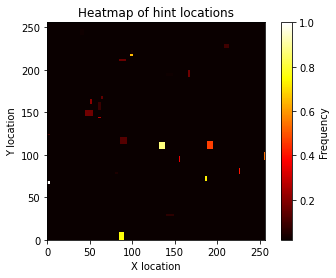

In [57]:

import matplotlib.pyplot as plt
# Initialize the heatmap
heatmap = np.zeros((256, 256))

# Convert the hints tensor to a NumPy array
hints_np = hints.numpy()

# For each image
for i in range(100):
    # Find the locations of the hints in the image
    y_locs, x_locs = np.nonzero(hints_np[i].sum(axis=0))
    
    # For each hint in the image
    for x, y in zip(x_locs, y_locs):
        # Add one to the corresponding location in the heatmap
        heatmap[y, x] += 1

# Normalize the heatmap
heatmap /= 100

# Plot the heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest', origin='lower', extent=[0, 256, 0, 256])
plt.colorbar(label='Frequency')
plt.xlabel('X location')
plt.ylabel('Y location')
plt.title('Heatmap of hint locations')
plt.show()

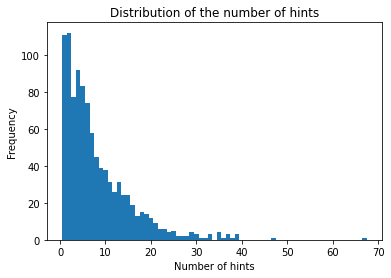

In [44]:



# Convert the number of hints to a NumPy array
num_hints_np = num_hints.numpy()

# Plot a histogram of the number of hints
plt.hist(num_hints_np, bins=range(1, int(num_hints_np.max())+2), align='left')
plt.xlabel('Number of hints')
plt.ylabel('Frequency')
plt.title('Distribution of the number of hints')
plt.show()

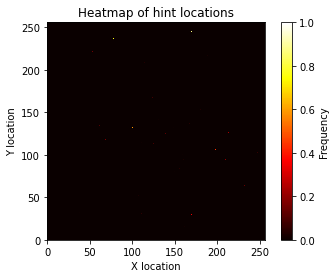

In [45]:
# Generate the hint locations
num_hints = generator.get_num_hints(10000)
locations = generator.get_sample_locations(num_hints, 256, 256)

# Initialize the heatmap
heatmap = np.zeros((256, 256))

# For each image
for i in range(10000):
    # For each hint in the image
    for j in range(num_hints[i].int()):
        # Add one to the corresponding location in the heatmap
        heatmap[locations[j, 0], locations[j, 1]] += 1

# Normalize the heatmap
heatmap /= 10000

# Plot the heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest', origin='lower', extent=[0, 256, 0, 256])
plt.colorbar(label='Frequency')
plt.xlabel('X location')
plt.ylabel('Y location')
plt.title('Heatmap of hint locations')
plt.show()


In [27]:
hints = generator.generate_hints(imgAB)
L_w_hints = torch.cat((imgL,hints),dim=1)
img_w_hints = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(L_w_hints).squeeze(0).detach().cpu()
            )
        )


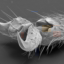

In [28]:
img_w_hints

In [20]:
%matplotlib widget
colorizer = ColorizerApp(imgRGB, diffusion_model, device)

colorizer.run()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
hintgen = RandomHintGenerator(
    input_size = 256,
    hint_size =4)

masks = hintgen(batch_size = 1)
hints = get_color_hints(imgAB = imgAB, hints = masks, avg_color = True)
imgLAB_w_hints = torch.cat((imgL,hints),dim=1)
hintsRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(imgLAB_w_hints).detach().cpu()
            ).squeeze(0)
        )
hintsRGB



In [ ]:
outputAB = diffusion_model.sample(imgLAB_w_hints.to(device))

In [ ]:
outpuLAB = torch.cat((imgL,outputAB.to("cpu")),dim=1)
outputRGB = transforms.ToPILImage()(
            lab_to_rgb(
                de_normalize_lab(outpuLAB).detach().cpu()
            ).squeeze(0))


outputRGB

In [ ]:
def get_new_dimensions(W, H, h):
    # calculate the new width while preserving the aspect ratio
    w = int((W * h) / H)
    # adjust the width to be divisible by 2 three times
    while w % 8 != 0:
        w -= 1
    return h, w
#convert to torch tensor
imgRGB = transforms.ToTensor()(img)
imgL = rgb_to_lab(imgRGB)[:1,:,:]


original_height, original_width = imgRGB.shape[1:]
print("original dimensions: ", original_height, original_width)
new_height, new_width = get_new_dimensions(original_width, original_height, 256)

imgRGB = transforms.Resize((new_height, new_width))(imgRGB)
print("new dimensions: ", imgRGB.shape[1:])





In [ ]:
#use ipywigdet linemagi
testImg = jimg#transforms.ToPILImage()(jimg)
testImg = testImg.convert('L').convert('RGB')

jupyter_colorizer = JupyterImageColorizer(testImg, diffusion_model,device=device)
jupyter_colorizer.display()


In [ ]:
7e-5+1

In [ ]:
colorizations_LAB = jupyter_colorizer.output_image_LAB_tensors

In [ ]:
colorizations_LAB =  transforms.Resize((original_height,original_width))(colorizations_LAB)
print(imgL.shape)
colorizations_LAB[:1,:1,:,:] = imgL

transforms.ToPILImage()(lab_to_rgb(colorizations_LAB).squeeze(0).detach().cpu())